<a href="https://colab.research.google.com/github/YoshifumiMiyagi/PECARN-Group1-/blob/main/PECARN_Group_1_CB_NN_TabNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
SEED = 42
threshold = 0.15
# ライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# CSVファイルを読み込む
df = pd.read_csv('/content/TBI PUD 10-08-2013.csv')
# 使用された説明変数とCTスキャンの必要性を示す目的変数をリストにする

variables_of_interest = [
    'AgeTwoPlus',         # 年齢
    'High_impact_InjSev', # 外傷の重症度
    'LOCSeparate',        # 意識喪失の履歴
    'LocLen',             # 意識喪失の持続時間
    'HA_verb',            # 頭痛の有無
    'HASeverity',         # 頭痛の重症度
    'Vomit',              # 嘔吐の履歴
    'VomitNbr',           # 嘔吐の回数
    'ActNorm',            # 保護者の観察
    'GCSTotal',           # GCSスコア
    'AMS',                # 精神状態の変化
    'SFxBas',             # 基底頭蓋骨骨折の兆候
    'SFxPalp',            # 触知可能な頭蓋骨骨折
    'Hema',               # 頭皮血腫
    'HemaLoc',            # 頭皮血腫の位置
#    'HospHeadPosCT',      # 目的変数（CTスキャンと2日以上の入院の必要性）
    'PosCT'               # 目的変数（CTスキャンの必要性）
]
# 説明変数と目的変数のみを抽出
df_selected = df[variables_of_interest]
# 92（該当なし）を除く。
dat = df_selected[df_selected['PosCT'] != 92]
dat.shape

(15899, 16)

In [ ]:
# 欠損値をRidgeをBaseとしたIterativeImputerで推定し、roundでカテゴリカル変数に丸める
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer(max_iter=10, random_state=SEED)
df2 = pd.DataFrame(np.round(imputer.fit_transform(dat)))
df2.columns = dat.columns

In [ ]:
# ホールドアウト法でtrain dataとtest dataに分割（層化サンプリング）
from sklearn.model_selection import train_test_split
X, y = df2.iloc[:,:-1], df2.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size=0.20, random_state=SEED)

# 外れ値除去(LOF)したのち、CatBoostベースのBalancedBaggingClassifierで学習と予測

In [ ]:
# 外れ値除去
from sklearn.neighbors import LocalOutlierFactor
local_outlier_factor = LocalOutlierFactor(n_neighbors=2,algorithm='auto', leaf_size=2, metric='minkowski', p=10, metric_params=None, n_jobs=None,contamination='auto', novelty=True)
local_outlier_factor.fit(x_train)
predicted = local_outlier_factor.predict(x_train)
X_train = x_train.loc[predicted > 0,:]
Y_train = y_train.loc[predicted > 0]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  should set `reset=False`.


In [ ]:
# CatBoostベースのBalancedBaggingClassifierで学習と予測
!pip install catboost
from catboost import CatBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier

In [ ]:
cb = CatBoostClassifier(verbose=False,random_state=SEED)
#cb = CatBoostClassifier(verbose=False,random_state=SEED,loss_function='Logloss',eval_metric='PRAUC')
#model_BBC_cb = cb
model_BBC_cb = BalancedBaggingClassifier(estimator=cb, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False,
                                   oob_score=False, warm_start=False, sampling_strategy='auto', replacement=False, n_jobs=None, verbose=0, sampler=None, random_state=SEED)
model_BBC_cb.fit(X_train, Y_train)

BalancedBaggingClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x7ed3c9aee5c0>,
                          random_state=42)

In [ ]:
y_pred_prob_CatBoost = model_BBC_cb.predict_proba(x_test)[:, 1]

In [ ]:
# 評価指数の確認
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc

# 予測値を二値化
y_pred = (y_pred_prob_CatBoost > threshold).astype(int)
# AUCの計算
auc = roc_auc_score(y_test, y_pred_prob_CatBoost)
print(f"AUC: {auc}")
# 混同行列の計算
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
Precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Precision:", Precision)
print("f1:", f1)
print("accuracy:", accuracy)
# 感度 (Recall) の計算
sensitivity = tp / (tp + fn)
print(f"感度 (Recall): {sensitivity}")
# 特異度 (Specificity) の計算
specificity = tn / (tn + fp)
print(f"特異度 (Specificity): {specificity}")

AUC: 0.823181678725931
Precision: 0.09467713787085515
f1: 0.17201743955608403
accuracy: 0.3430817610062893
感度 (Recall): 0.9393939393939394
特異度 (Specificity): 0.2963716514072567


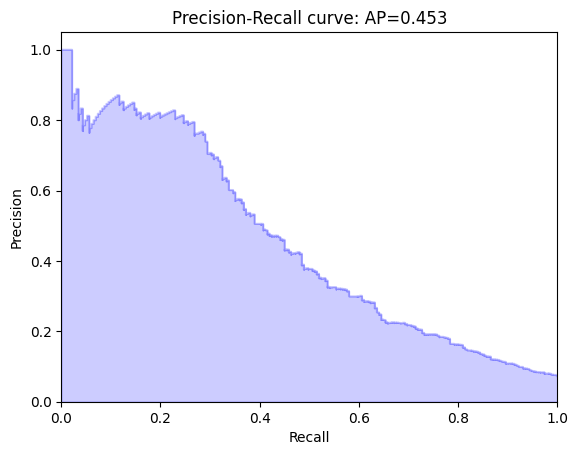

In [ ]:
# prompt: Precision-Recall曲線

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
# Precision-Recall曲線の計算
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_CatBoost)
average_precision = average_precision_score(y_test, y_pred_prob_CatBoost)

# Precision-Recall曲線のプロット
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.3f}'.format(average_precision))
plt.show()

# Neural network (keras)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint

modelCheckpoint = ModelCheckpoint(filepath = 'model_0.keras',
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  save_weights_only=False,
                                  mode='min')

In [ ]:
import os
import random

os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(units=9, activation="relu", input_shape=(x_train.shape[-1],) ),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(units=9, activation="relu"),
        tf.keras.layers.Dense(units=1, activation="sigmoid"),
    ]
)

learning_rate = 0.001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss="binary_crossentropy",
              metrics=['auc']
             )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler  = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test   = scaler.transform(x_test)

In [ ]:
history = model.fit(x_train, y_train,
          epochs=50,
          batch_size=100,
          validation_data=(x_test, y_test),
          callbacks=[modelCheckpoint],
          verbose=-1)

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.52120, saving model to model_0.keras
Epoch 2/50

Epoch 2: val_loss improved from 0.52120 to 0.26069, saving model to model_0.keras
Epoch 3/50

Epoch 3: val_loss improved from 0.26069 to 0.24386, saving model to model_0.keras
Epoch 4/50

Epoch 4: val_loss improved from 0.24386 to 0.23297, saving model to model_0.keras
Epoch 5/50

Epoch 5: val_loss improved from 0.23297 to 0.22673, saving model to model_0.keras
Epoch 6/50

Epoch 6: val_loss improved from 0.22673 to 0.22397, saving model to model_0.keras
Epoch 7/50

Epoch 7: val_loss improved from 0.22397 to 0.22200, saving model to model_0.keras
Epoch 8/50

Epoch 8: val_loss improved from 0.22200 to 0.22071, saving model to model_0.keras
Epoch 9/50

Epoch 9: val_loss improved from 0.22071 to 0.21933, saving model to model_0.keras
Epoch 10/50

Epoch 10: val_loss improved from 0.21933 to 0.21844, saving model to model_0.keras
Epoch 11/50

Epoch 11: val_loss improved from 0.21844 to 0.217

In [ ]:
# テストデータでの予測
model = tf.keras.models.load_model('/content/model_0.keras')
y_pred_prob_NN = model.predict(x_test)
# 予測値を二値化
y_pred = (y_pred_prob_NN > threshold).astype(int)
# AUCの計算
auc = roc_auc_score(y_test, y_pred_prob_NN)
print(f"AUC: {auc}")
# 混同行列の計算
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
Precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Precision:", Precision)
print("f1:", f1)
print("accuracy:", accuracy)
# 感度 (Recall) の計算
sensitivity = tp / (tp + fn)
print(f"感度 (Recall): {sensitivity}")
# 特異度 (Specificity) の計算
specificity = tn / (tn + fp)
print(f"特異度 (Specificity): {specificity}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC: 0.8105220200845837
Precision: 0.3264094955489614
f1: 0.3873239436619718
accuracy: 0.8905660377358491
感度 (Recall): 0.47619047619047616
特異度 (Specificity): 0.9230247541539505


In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_NN)
average_precision = average_precision_score(y_test, y_pred_prob_NN)

print('Precision-Recall curve: AP={0:0.3f}'.format(average_precision))

Precision-Recall curve: AP=0.407


# Tabnet

In [ ]:
!pip install pytorch_tabnet

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

TC = TabNetClassifier(seed = SEED)  #TabNetRegressor()
TC.fit(
  x_train, y_train,
  eval_set=[(x_test, y_test)]
)
y_pred_prob_Tab = TC.predict_proba(x_test)

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.29745 | val_0_auc: 0.56139 |  0:00:01s
epoch 1  | loss: 0.2354  | val_0_auc: 0.49226 |  0:00:02s
epoch 2  | loss: 0.22741 | val_0_auc: 0.52427 |  0:00:05s
epoch 3  | loss: 0.22124 | val_0_auc: 0.51187 |  0:00:08s
epoch 4  | loss: 0.21976 | val_0_auc: 0.57784 |  0:00:09s
epoch 5  | loss: 0.21712 | val_0_auc: 0.6865  |  0:00:11s
epoch 6  | loss: 0.21643 | val_0_auc: 0.6912  |  0:00:13s
epoch 7  | loss: 0.21387 | val_0_auc: 0.68053 |  0:00:15s
epoch 8  | loss: 0.21431 | val_0_auc: 0.7123  |  0:00:17s
epoch 9  | loss: 0.21449 | val_0_auc: 0.7445  |  0:00:20s
epoch 10 | loss: 0.20776 | val_0_auc: 0.75561 |  0:00:24s
epoch 11 | loss: 0.2049  | val_0_auc: 0.76072 |  0:00:26s
epoch 12 | loss: 0.20515 | val_0_auc: 0.7671  |  0:00:28s
epoch 13 | loss: 0.20851 | val_0_auc: 0.75404 |  0:00:29s
epoch 14 | loss: 0.20842 | val_0_auc: 0.76533 |  0:00:31s
epoch 15 | loss: 0.20835 | val_0_auc: 0.77505 |  0:00:33s
epoch 16 | loss: 0.20449 | val_0_auc: 0.77907 |  0:00:37s
epoch 17 | los

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
# 予測値を二値化
y_pred = (y_pred_prob_Tab[:,1] > threshold).astype(int)
# AUCの計算
auc = roc_auc_score(y_test, y_pred_prob_Tab[:,1])
print(f"AUC: {auc}")
# 混同行列の計算
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
Precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Precision:", Precision)
print("f1:", f1)
print("accuracy:", accuracy)
# 感度 (Recall) の計算
sensitivity = tp / (tp + fn)
print(f"感度 (Recall): {sensitivity}")
# 特異度 (Specificity) の計算
specificity = tn / (tn + fp)
print(f"特異度 (Specificity): {specificity}")

AUC: 0.8021502629844441
Precision: 0.33762057877813506
f1: 0.38745387453874536
accuracy: 0.8955974842767296
感度 (Recall): 0.45454545454545453
特異度 (Specificity): 0.9301458121397084


In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob_Tab[:,1])
average_precision = average_precision_score(y_test, y_pred_prob_Tab[:,1])

print('Precision-Recall curve: AP={0:0.3f}'.format(average_precision))

Precision-Recall curve: AP=0.375


# CatBoostとNeural networkとTabnetの予測値をBlending

In [ ]:
result = (y_pred_prob_CatBoost + y_pred_prob_NN.flatten() + y_pred_prob_Tab[:,1]) / 3
print(result.shape)

(3180,)


In [ ]:
# 予測値を二値化
y_pred = (result > 0.05).astype(int)
# AUCの計算
auc = roc_auc_score(y_test, result)
print(f"ROC-AUC: {auc}")
# 混同行列の計算
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
Precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("Precision:", Precision)
print("f1:", f1)
print("accuracy:", accuracy)
# 感度 (Recall) の計算
sensitivity = tp / (tp + fn)
print(f"感度 (Recall): {sensitivity}")
# 特異度 (Specificity) の計算
specificity = tn / (tn + fp)
print(f"特異度 (Specificity): {specificity}")
precision, recall, _ = precision_recall_curve(y_test, result)
average_precision = average_precision_score(y_test, result)

print('PR-AUC: {0:0.3f}'.format(average_precision))

ROC-AUC: 0.825647845993726
Precision: 0.08159597411933861
f1: 0.1506803849983405
accuracy: 0.19528301886792454
感度 (Recall): 0.9826839826839827
特異度 (Specificity): 0.13360461173279078
PR-AUC: 0.429


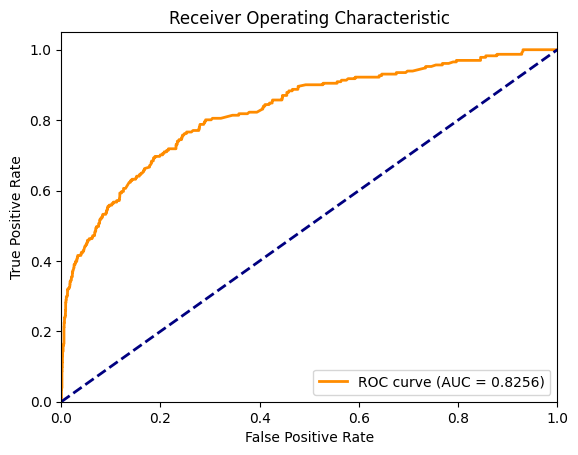

In [ ]:
# ROC曲線の作成
fpr, tpr, thresholds = roc_curve(y_test, result)

# AUCの計算
from sklearn.metrics import auc
roc_auc = auc(fpr, tpr)

# ROC曲線のプロット
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

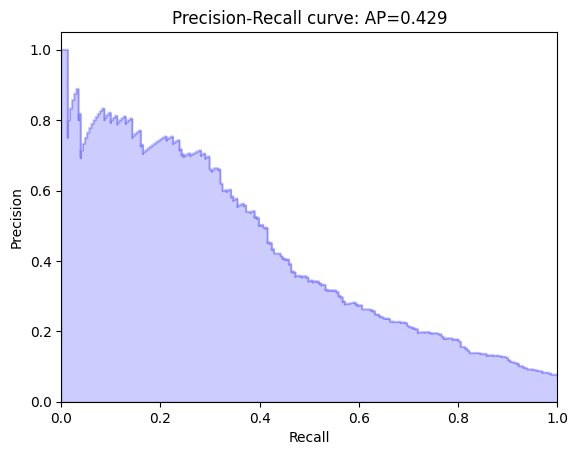

In [ ]:
# prompt: Precision-Recall曲線

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
# Precision-Recall曲線の計算
precision, recall, _ = precision_recall_curve(y_test, result)
average_precision = average_precision_score(y_test, result)

# Precision-Recall曲線のプロット
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.3f}'.format(average_precision))
plt.show()


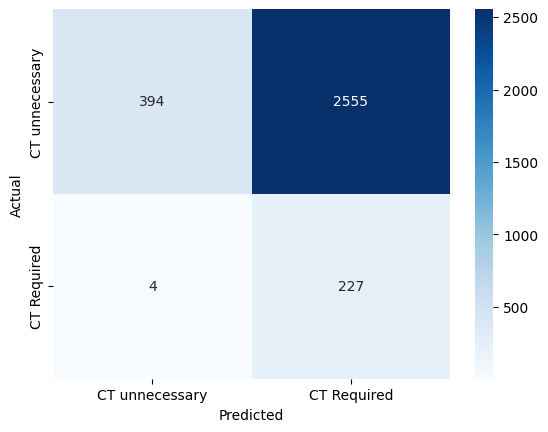

In [ ]:
from sklearn.metrics import confusion_matrix
plt.figure()
cm = confusion_matrix(y_test, y_pred)
classes=['CT unnecessary', 'CT Required']
sns.heatmap(cm, annot=True,xticklabels=classes, yticklabels=classes,cmap='Blues',fmt=".0f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature selection

In [ ]:
feature_importances =np.mean([est.steps[1][1].feature_importances_ for est in model_BBC_cb.estimators_], axis=0)

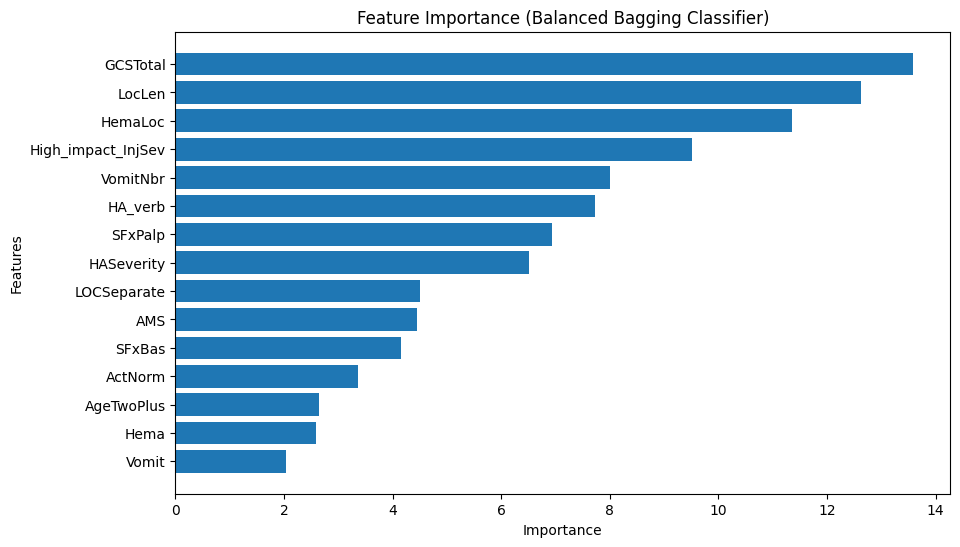

In [ ]:
# 特徴量の重要度をソート
sorted_idx = feature_importances.argsort()
# 特徴量の重要度を表示
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], feature_importances[sorted_idx])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance (Balanced Bagging Classifier)")
plt.show()


In [ ]:
Feat5 = X.columns[sorted_idx[-5:]]
Feat5

Index(['VomitNbr', 'High_impact_InjSev', 'HemaLoc', 'LocLen', 'GCSTotal'], dtype='object')

In [ ]:
x_train_f5, x_test_f5, y_train_f5, y_test_f5 = train_test_split(X[Feat5],y, test_size=0.20, random_state=SEED)

In [ ]:
model_BBC_cb.fit(x_train_f5, y_train_f5)
y_pred_prob_CatBoost_Feat5 = model_BBC_cb.predict_proba(x_test_f5)[:, 1]

In [ ]:
# 予測値を二値化
y_pred_f5 = (y_pred_prob_CatBoost_Feat5 > threshold).astype(int)
# AUCの計算
auc = roc_auc_score(y_test_f5, y_pred_prob_CatBoost_Feat5)
print(f"AUC: {auc}")
# 混同行列の計算
tn, fp, fn, tp = confusion_matrix(y_test_f5, y_pred_f5).ravel()
Precision = precision_score(y_test_f5, y_pred_f5)
f1 = f1_score(y_test_f5, y_pred_f5)
accuracy = accuracy_score(y_test_f5, y_pred_f5)
print("Precision:", Precision)
print("f1:", f1)
print("accuracy:", accuracy)
# 感度 (Recall) の計算
sensitivity = tp / (tp + fn)
print(f"感度 (Recall): {sensitivity}")
# 特異度 (Specificity) の計算
specificity = tn / (tn + fp)
print(f"特異度 (Specificity): {specificity}")

AUC: 0.8052571849668386
Precision: 0.0768446106766406
f1: 0.1425417849258909
accuracy: 0.1449685534591195
感度 (Recall): 0.9826086956521739
特異度 (Specificity): 0.07966101694915254


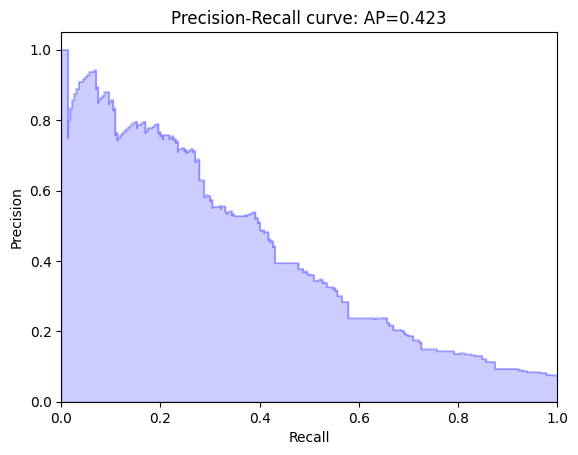

In [ ]:
precision, recall, _ = precision_recall_curve(y_test_f5, y_pred_prob_CatBoost_Feat5)
average_precision = average_precision_score(y_test_f5, y_pred_prob_CatBoost_Feat5)

# Precision-Recall曲線のプロット
plt.figure()
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.3f}'.format(average_precision))
plt.show()

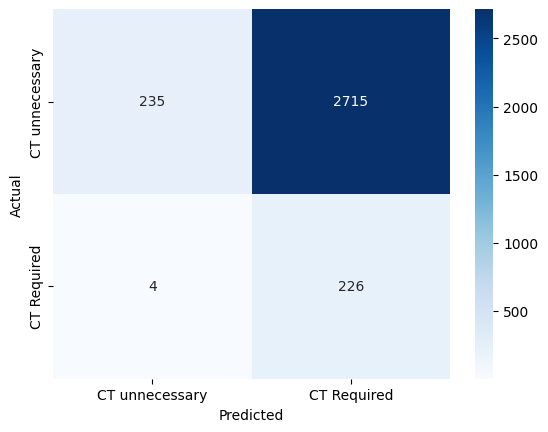

In [ ]:
from sklearn.metrics import confusion_matrix
plt.figure()
cm = confusion_matrix(y_test_f5, y_pred_f5)
classes=['CT unnecessary', 'CT Required']
sns.heatmap(cm, annot=True,xticklabels=classes, yticklabels=classes,cmap='Blues',fmt=".0f")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 結論

# Model_1
15の説明変数を用いて、およそ20%のCT不応例を除外するモデル

# Model_2
**（'SFxPalp', 'High_impact_InjSev', 'HemaLoc', 'GCSTotal', 'LocLen'）**
5つの説明変数を用いて、およそ10%のCT不応例を除外するモデル